In [2]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline

pd.set_option('display.max_rows', 10)

# Adatok betöltése

In [3]:
import psycopg2
import pandas as pd

def load_data_reg():
    # Adatbázis csatlakozás
    connection = psycopg2.connect(
        host="*****",
        database="postgres",
        user="*****",
        password="*****")
    cursor = connection.cursor()

    # Adatok lekérdezése
    query = "SELECT * FROM registrations;"
    cursor.execute(query)
    records = cursor.fetchall()
    column_names = [desc[0] for desc in cursor.description]

    # Adatbázis kapcsolat bezárása
    cursor.close()
    connection.close()

    # DataFrame létrehozása
    registrations = pd.DataFrame(records, columns=column_names)
    return registrations

# DataFrame frissítése
registrations = load_data_reg()
registrations

,file_name,reg_date,reg_time,user_id,event,birth_year,device,country,source
0,day_1,2022-10-14,00:32:11,1000001,registration,1983,android,sweden,invite_a_friend
1,day_1,2022-10-14,00:55:42,1000002,registration,1986,ios,united_states,invite_a_friend
2,day_1,2022-10-14,01:05:20,1000003,registration,1989,error,sweden,invite_a_friend
3,day_1,2022-10-14,01:23:24,1000004,registration,1994,error,germany,invite_a_friend
4,day_1,2022-10-14,01:24:16,1000005,registration,1986,ios,united_states,invite_a_friend
...,...,...,...,...,...,...,...,...,...
100409,day_202,2023-05-03,23:51:44,1100410,registration,1984,android,united_states,invite_a_friend
100410,day_202,2023-05-03,23:54:35,1100411,registration,1987,error,philippines,invite_a_friend
100411,day_202,2023-05-03,23:54:49,1100412,registration,1986,android,sweden,invite_a_friend
100412,day_202,2023-05-03,23:57:15,1100413,registration,1984,android,united_states,paid


In [4]:
import psycopg2
import pandas as pd

def load_data_ft():
    # Adatbázis csatlakozás
    connection = psycopg2.connect(
        host="*****",
        database="postgres",
        user="*****",
        password="*****")
    cursor = connection.cursor()

    # Adatok lekérdezése
    query = "SELECT * FROM free_tree;"
    cursor.execute(query)
    records = cursor.fetchall()
    column_names = [desc[0] for desc in cursor.description]

    # Adatbázis kapcsolat bezárása
    cursor.close()
    connection.close()

    # DataFrame létrehozása
    free_tree = pd.DataFrame(records, columns=column_names)
    return free_tree

# DataFrame frissítése
free_tree = load_data_ft()
free_tree

,file_name,send_date,user_id,event
0,day_1,2022-10-14,1000001,sent_a_free_tree
1,day_1,2022-10-14,1000001,sent_a_free_tree
2,day_1,2022-10-14,1000001,sent_a_free_tree
3,day_1,2022-10-14,1000002,sent_a_free_tree
4,day_1,2022-10-14,1000002,sent_a_free_tree
...,...,...,...,...
928354,day_202,2023-05-03,1091883,sent_a_free_tree
928355,day_202,2023-05-03,1070867,sent_a_free_tree
928356,day_202,2023-05-03,1099228,sent_a_free_tree
928357,day_202,2023-05-03,1099228,sent_a_free_tree


In [5]:
import psycopg2
import pandas as pd

def load_data_st():
    # Adatbázis csatlakozás
    connection = psycopg2.connect(
        host="*****",
        database="postgres",
        user="*****",
        password="*****")
    cursor = connection.cursor()

    # Adatok lekérdezése
    query = "SELECT * FROM super_tree;"
    cursor.execute(query)
    records = cursor.fetchall()
    column_names = [desc[0] for desc in cursor.description]

    # Adatbázis kapcsolat bezárása
    cursor.close()
    connection.close()

    # DataFrame létrehozása
    super_tree = pd.DataFrame(records, columns=column_names)
    return super_tree

# DataFrame frissítése
super_tree = load_data_st()
super_tree

,file_name,send_date,user_id,event
0,day_1,2022-10-14,1000007,sent_a_super_tree
1,day_1,2022-10-14,1000010,sent_a_super_tree
2,day_1,2022-10-14,1000011,sent_a_super_tree
3,day_1,2022-10-14,1000019,sent_a_super_tree
4,day_1,2022-10-14,1000022,sent_a_super_tree
...,...,...,...,...
61371,day_202,2023-05-03,1100400,sent_a_super_tree
61372,day_202,2023-05-03,1100400,sent_a_super_tree
61373,day_202,2023-05-03,1100400,sent_a_super_tree
61374,day_202,2023-05-03,1100400,sent_a_super_tree


# Mire prediktáljunk? 

In [10]:
#Mikor küldte az első fizetős fát a user? Azaz mikor küldte a második super_tree-jét?
pt_send_date = super_tree.groupby('user_id')[['send_date']].nth(1).reset_index()
pt_send_date = pt_send_date.rename(columns={'send_date': 'pt_send_date'})
pt_send_date

,user_id,pt_send_date
0,1000010,2022-10-15
1,1000011,2022-10-15
2,1000022,2022-10-14
3,1000026,2022-10-15
4,1000037,2022-10-14
...,...,...
14033,1100364,2023-05-03
14034,1100386,2023-05-03
14035,1100390,2023-05-03
14036,1100396,2023-05-03


In [15]:
#A regisztrációhoz képest mikor volt a userek első paid_tree küldése?

tmp = registrations.merge(pt_send_date, how='outer', on = 'user_id')
tmp = tmp[['reg_date','user_id','pt_send_date']]

import datetime
tmp['reg_date'] = pd.to_datetime(tmp['reg_date'])
tmp['pt_send_date'] = pd.to_datetime(tmp['pt_send_date'])

for i in range(0,15):
    filtered_rows = tmp[(tmp.reg_date <= tmp.pt_send_date) & (tmp.pt_send_date <= (tmp.reg_date + pd.Timedelta(days=i)))]
    row_count = filtered_rows.shape[0]
    print(str(i) + ' nap elteltével a paid_tree-t küldők száma: ' + str(row_count))

0 nap elteltével a paid_tree-t küldők száma: 9150
1 nap elteltével a paid_tree-t küldők száma: 13651
2 nap elteltével a paid_tree-t küldők száma: 13843
3 nap elteltével a paid_tree-t küldők száma: 13918
4 nap elteltével a paid_tree-t küldők száma: 13959
5 nap elteltével a paid_tree-t küldők száma: 13993
6 nap elteltével a paid_tree-t küldők száma: 14011
7 nap elteltével a paid_tree-t küldők száma: 14030
8 nap elteltével a paid_tree-t küldők száma: 14035
9 nap elteltével a paid_tree-t küldők száma: 14037
10 nap elteltével a paid_tree-t küldők száma: 14038
11 nap elteltével a paid_tree-t küldők száma: 14038
12 nap elteltével a paid_tree-t küldők száma: 14038
13 nap elteltével a paid_tree-t küldők száma: 14038
14 nap elteltével a paid_tree-t küldők száma: 14038


### >> Tehát a regisztrációtól számítva nagyjából az első 3 nap az az időszak, amikor dinamikusan nő a fizetős userek száma, úgyhogy prediktáljunk erre...

# Adatok formázása

In [19]:
pd.set_option('display.max_rows', 30)

In [36]:
#hány free_tree-t küldött a user a regisztrációt követő első 3 napban? Megjegyzés: reg_date = first_ft_send_date
tmp = free_tree.groupby(['user_id','send_date']).count()[['event']].reset_index()
tmp = tmp.rename(columns={'send_date': 'ft_send_date'})

tmp['ft_send_date'] = pd.to_datetime(tmp['ft_send_date'])

tmp2 = tmp.groupby('user_id')[['ft_send_date']].first().reset_index()
tmp2 = tmp2.rename(columns={'ft_send_date': 'first_ft_send'})

tmp3 = tmp.merge(tmp2, how='left', on='user_id')

tmp3['first_ft_send'] = pd.to_datetime(tmp3['first_ft_send'])

tmp3 = tmp3[tmp3.ft_send_date <= (tmp3.first_ft_send + pd.Timedelta(days=3))]
tmp3 = tmp3.groupby(['user_id']).sum()[['event']].reset_index()
tmp3

ft_sendings = tmp3.rename(columns={'event': 'ft_sendings'})
ft_sendings

,user_id,ft_sendings
0,1000001,5
1,1000002,4
2,1000003,14
3,1000005,5
4,1000006,4
5,1000007,8
6,1000009,11
7,1000010,1
8,1000011,10
9,1000012,21


In [47]:
#elküldte-e az első super_tree-jét a user a regisztrációt követő első 3 napban?
tmp = super_tree.groupby(['user_id'])[['send_date']].first().reset_index()
tmp = tmp.rename(columns={'send_date': 'first_st_send'})

tmp = registrations.merge(tmp, how='left', on='user_id')
tmp = tmp[['reg_date','user_id','first_st_send']]

tmp['reg_date'] = pd.to_datetime(tmp['reg_date'])
tmp['first_st_send'] = pd.to_datetime(tmp['first_st_send'])

tmp = tmp[tmp.first_st_send <= (tmp.reg_date + pd.Timedelta(days=3))]

tmp = tmp[['user_id','first_st_send']]
tmp['first_st_send'] = 1

st_sending = tmp
st_sending

,user_id,first_st_send
6,1000007,1
9,1000010,1
10,1000011,1
12,1000013,1
18,1000019,1
21,1000022,1
25,1000026,1
29,1000030,1
31,1000032,1
36,1000037,1


In [48]:
#kik küldtek paid_tree-t és mikor volt az első paid_tree küldés (azaz a második super_tree küldés)
pt_send_date = super_tree.groupby('user_id')[['send_date']].nth(1).reset_index()
pt_send_date = pt_send_date.rename(columns={'send_date': 'pt_send_date'})
pt_send_date

,user_id,pt_send_date
0,1000010,2022-10-15
1,1000011,2022-10-15
2,1000022,2022-10-14
3,1000026,2022-10-15
4,1000037,2022-10-14
5,1000040,2022-10-14
6,1000073,2022-10-14
7,1000080,2022-10-14
8,1000082,2022-10-14
9,1000086,2022-10-15


In [49]:
#regisztráció napjától számítva 3 napon belül küldött-e fizetős fát a user?
tmp = registrations.merge(pt_send_date, on = 'user_id')

tmp['reg_date'] = pd.to_datetime(tmp['reg_date'])
tmp['pt_send_date'] = pd.to_datetime(tmp['pt_send_date'])

tmp = tmp[(tmp.reg_date <= tmp.pt_send_date) & (tmp.pt_send_date <= (tmp.reg_date + pd.Timedelta(days=3)))]

pt_sending = tmp[(tmp.reg_date <= tmp.pt_send_date) & (tmp.pt_send_date <= (tmp.reg_date + pd.Timedelta(days=3)))]
pt_sending = pt_sending[['user_id','pt_send_date']]
pt_sending = pt_sending.rename(columns={'pt_send_date': 'pt_sending'})

pt_sending['pt_sending']=1
pt_sending

,user_id,pt_sending
0,1000010,1
1,1000011,1
2,1000022,1
3,1000026,1
4,1000037,1
5,1000040,1
6,1000073,1
7,1000080,1
8,1000082,1
9,1000086,1


# known és unknown dataset definiálása

 ## known = összes eddigi adat - az elmúlt 1 hét   ///   unknown = elmúlt 1 hét

In [50]:
current_date = datetime.datetime.now().date()
current_date - datetime.timedelta(days=8)

datetime.date(2023, 4, 26)

In [51]:
df = registrations[['user_id','reg_date','birth_year','device','country','source']]
df = df.merge(ft_sendings, how='inner', on='user_id')
df = df.merge(st_sending, how='left', on='user_id').fillna(0)
df = df.merge(pt_sending, how='left', on='user_id').fillna(0)

df['first_st_send'] = df['first_st_send'].astype(int)
df['pt_sending'] = df['pt_sending'].astype(int)

df

,user_id,reg_date,birth_year,device,country,source,ft_sendings,first_st_send,pt_sending
0,1000001,2022-10-14,1983,android,sweden,invite_a_friend,5,0,0
1,1000002,2022-10-14,1986,ios,united_states,invite_a_friend,4,0,0
2,1000003,2022-10-14,1989,error,sweden,invite_a_friend,14,0,0
3,1000005,2022-10-14,1986,ios,united_states,invite_a_friend,5,0,0
4,1000006,2022-10-14,1983,android,sweden,invite_a_friend,4,0,0
5,1000007,2022-10-14,1994,android,sweden,invite_a_friend,8,1,0
6,1000009,2022-10-14,1989,android,united_states,invite_a_friend,11,0,0
7,1000010,2022-10-14,1993,error,brazil,invite_a_friend,1,1,1
8,1000011,2022-10-14,1995,error,united_states,invite_a_friend,10,1,1
9,1000012,2022-10-14,1986,error,united_states,invite_a_friend,21,0,0


In [52]:
df['reg_date'] = pd.to_datetime(df['reg_date'])
known = df[df.reg_date <= (current_date - datetime.timedelta(days=8))]
unknown = df[df.reg_date > (current_date - datetime.timedelta(days=8))]

In [53]:
known

,user_id,reg_date,birth_year,device,country,source,ft_sendings,first_st_send,pt_sending
0,1000001,2022-10-14,1983,android,sweden,invite_a_friend,5,0,0
1,1000002,2022-10-14,1986,ios,united_states,invite_a_friend,4,0,0
2,1000003,2022-10-14,1989,error,sweden,invite_a_friend,14,0,0
3,1000005,2022-10-14,1986,ios,united_states,invite_a_friend,5,0,0
4,1000006,2022-10-14,1983,android,sweden,invite_a_friend,4,0,0
5,1000007,2022-10-14,1994,android,sweden,invite_a_friend,8,1,0
6,1000009,2022-10-14,1989,android,united_states,invite_a_friend,11,0,0
7,1000010,2022-10-14,1993,error,brazil,invite_a_friend,1,1,1
8,1000011,2022-10-14,1995,error,united_states,invite_a_friend,10,1,1
9,1000012,2022-10-14,1986,error,united_states,invite_a_friend,21,0,0


In [54]:
unknown

,user_id,reg_date,birth_year,device,country,source,ft_sendings,first_st_send,pt_sending
70661,1091439,2023-04-27,1984,android,united_states,invite_a_friend,5,0,0
70662,1091440,2023-04-27,1990,android,united_states,invite_a_friend,15,1,0
70663,1091442,2023-04-27,1985,error,united_states,invite_a_friend,9,0,0
70664,1091444,2023-04-27,1984,error,united_states,google,2,0,0
70665,1091447,2023-04-27,1993,error,sweden,invite_a_friend,9,1,1
70666,1091448,2023-04-27,1994,error,philippines,invite_a_friend,5,0,0
70667,1091450,2023-04-27,1989,android,sweden,google,7,0,0
70668,1091451,2023-04-27,1983,android,united_states,google,1,0,0
70669,1091452,2023-04-27,1987,error,united_states,invite_a_friend,20,1,0
70670,1091453,2023-04-27,1988,android,brazil,invite_a_friend,3,1,1


# Adatok feltérképezése manuálisan


In [56]:
pd.set_option('display.max_rows', 10)

In [57]:
known.groupby(['birth_year','pt_sending'])[['user_id']].count()

user_id
birth_year pt_sending         
1980       0               181
1981       0               632
1982       0              1565
1983       0              2669
1984       0              4218
...                        ...
1996       1               132
1997       0               199
           1                30
1998       0                54
           1                 1

[31 rows x 1 columns]

In [58]:
known.groupby(['country','pt_sending'])[['user_id']].count()

user_id
country       pt_sending         
brazil        0              8830
              1              4440
germany       0              2902
philippines   0              6453
sweden        0             10879
              1                50
united_states 0             29720
              1              7387

In [59]:
known.groupby(['source','pt_sending'])[['user_id']].count()

user_id
source          pt_sending         
article         0              8349
                1               236
google          0             10087
                1              1692
invite_a_friend 0             36499
                1              9949
paid            0              3849

In [60]:
known.groupby(['ft_sendings','pt_sending'])[['user_id']].count()

user_id
ft_sendings pt_sending         
1           0             10427
            1              1037
2           0              7679
            1               925
3           0              5601
...                         ...
32          1                10
33          0                 7
            1                 4
34          0                 4
            1                 2

[68 rows x 1 columns]

In [61]:
known.groupby(['first_st_send','pt_sending'])[['user_id']].count()

user_id
first_st_send pt_sending         
0             0             48690
1             0             10094
              1             11877

# Adatok előkészítése a RF-hez

In [62]:
known

,user_id,reg_date,birth_year,device,country,source,ft_sendings,first_st_send,pt_sending
0,1000001,2022-10-14,1983,android,sweden,invite_a_friend,5,0,0
1,1000002,2022-10-14,1986,ios,united_states,invite_a_friend,4,0,0
2,1000003,2022-10-14,1989,error,sweden,invite_a_friend,14,0,0
3,1000005,2022-10-14,1986,ios,united_states,invite_a_friend,5,0,0
4,1000006,2022-10-14,1983,android,sweden,invite_a_friend,4,0,0
...,...,...,...,...,...,...,...,...,...
70656,1091431,2023-04-26,1995,android,united_states,article,2,0,0
70657,1091433,2023-04-26,1993,android,united_states,invite_a_friend,14,1,1
70658,1091435,2023-04-26,1988,android,brazil,invite_a_friend,10,1,1
70659,1091436,2023-04-26,1993,android,united_states,invite_a_friend,10,1,1


In [63]:
birth_year_decoder = {1970: 0, 1971: 1, 1972: 2, 1973: 3, 1974: 4, 1975: 5, 1976: 6, 1977: 7, 1978: 8, 1979: 9, 
                      1980: 10, 1981: 11, 1982: 12, 1983: 13, 1984: 14, 1985: 15, 1986: 16, 1987: 17, 1988: 18, 1989: 19,
                      1990: 20, 1991: 21, 1992: 22, 1993: 23, 1994: 24, 1995: 25, 1996: 26, 1997: 27, 1998: 28, 1999: 29,
                      2000: 30}
known['birth_year'] = known['birth_year'].map(birth_year_decoder)


country_decoder = {'united_states': 0, 'sweden': 1, 'germany': 2, 
                   'brazil': 3, 'philippines': 4}
known['country'] = known['country'].map(country_decoder)


source_decoder = {'article': 0, 'google': 1, 
                   'invite_a_friend': 2, 'paid': 3}
known['source'] = known['source'].map(source_decoder)


device_decoder = {'android': 0, 'ios': 1, 'error': 2}
known['device'] = known['device'].map(device_decoder)


known

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

,user_id,reg_date,birth_year,device,country,source,ft_sendings,first_st_send,pt_sending
0,1000001,2022-10-14,13,0,1,2,5,0,0
1,1000002,2022-10-14,16,1,0,2,4,0,0
2,1000003,2022-10-14,19,2,1,2,14,0,0
3,1000005,2022-10-14,16,1,0,2,5,0,0
4,1000006,2022-10-14,13,0,1,2,4,0,0
...,...,...,...,...,...,...,...,...,...
70656,1091431,2023-04-26,25,0,0,0,2,0,0
70657,1091433,2023-04-26,23,0,0,2,14,1,1
70658,1091435,2023-04-26,18,0,3,2,10,1,1
70659,1091436,2023-04-26,23,0,0,2,10,1,1


# RandomForestClassifier

In [64]:
x = known[['birth_year', 'device', 'country', 'source', 'ft_sendings', 'first_st_send']]
y = known['pt_sending']

In [65]:
model = RandomForestClassifier(n_estimators = 50)
model = model.fit(x, y)

In [66]:
model

RandomForestClassifier(n_estimators=50)

In [68]:
sample_user = [23, 0, 0, 2, 10, 1]
model.predict([sample_user])

array([1])

In [69]:
for index, row in known.head(100).iterrows():
    print(model.predict([[row['birth_year'], row['device'], row['country'], row['source'], row['ft_sendings'], row['first_st_send']]]))

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]


# Ellenőrzés

In [70]:
known['predicted'] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [71]:
known

,user_id,reg_date,birth_year,device,country,source,ft_sendings,first_st_send,pt_sending,predicted
0,1000001,2022-10-14,13,0,1,2,5,0,0,0
1,1000002,2022-10-14,16,1,0,2,4,0,0,0
2,1000003,2022-10-14,19,2,1,2,14,0,0,0
3,1000005,2022-10-14,16,1,0,2,5,0,0,0
4,1000006,2022-10-14,13,0,1,2,4,0,0,0
...,...,...,...,...,...,...,...,...,...,...
70656,1091431,2023-04-26,25,0,0,0,2,0,0,0
70657,1091433,2023-04-26,23,0,0,2,14,1,1,0
70658,1091435,2023-04-26,18,0,3,2,10,1,1,0
70659,1091436,2023-04-26,23,0,0,2,10,1,1,0


In [72]:
predicted_labels = []
for index, row in known.iterrows():
    predicted_label = model.predict([[row['birth_year'], row['device'], row['country'], row['source'], row['ft_sendings'], row['first_st_send']]])[0]
    predicted_labels.append(predicted_label)

known['predicted'] = predicted_labels

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [77]:
known_check = known[['pt_sending','predicted']]
known_check

,pt_sending,predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
70656,0,0
70657,1,1
70658,1,0
70659,1,1


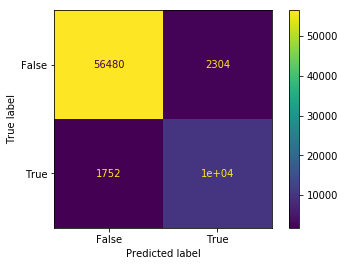

In [74]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

actual = known_check['pt_sending']
predicted = known_check['predicted']

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

# A modell prediktáló képessége a training_set-en:

Pontosság (accuracy): a helyesen osztályozott esetek aránya az összes esethez képest.
Accuracy = (56480 + 10000) / (56480 + 10000 + 1757 + 2304) = 0.945

### Tehát a modell pontossága 94,5%.

Pontosság (precision): a pozitív osztályozású esetek közül hány helyes.
Precision = 10000 / (10000 + 2304) = 0.8128

### Tehát a modell pontossága 81,28% a pozitív osztály esetén.

Érzékenység (recall, sensitivity): a valódi pozitív esetek közül hányat osztályozott helyesen a modell.
Recall = 10000 / (10000 + 1757) = 0.8505

### Tehát a modell érzékenysége 85,05% a pozitív osztály esetén.

F1-pontszám (F1-score): a pontosság és az érzékenység harmonikus középértéke.
F1-score = 2 * (Precision * Recall) / (Precision + Recall) = 2 * (0.8128 * 0.8505) / (0.8128 + 0.8505) = 0.8313

### Tehát a modell F1-pontszáma 83,13%.



# Prediktálás az unknown datasetben

In [78]:
unknown

,user_id,reg_date,birth_year,device,country,source,ft_sendings,first_st_send,pt_sending
70661,1091439,2023-04-27,1984,android,united_states,invite_a_friend,5,0,0
70662,1091440,2023-04-27,1990,android,united_states,invite_a_friend,15,1,0
70663,1091442,2023-04-27,1985,error,united_states,invite_a_friend,9,0,0
70664,1091444,2023-04-27,1984,error,united_states,google,2,0,0
70665,1091447,2023-04-27,1993,error,sweden,invite_a_friend,9,1,1
...,...,...,...,...,...,...,...,...,...
77488,1100409,2023-05-03,1995,android,sweden,invite_a_friend,1,0,0
77489,1100410,2023-05-03,1984,android,united_states,invite_a_friend,6,0,0
77490,1100411,2023-05-03,1987,error,philippines,invite_a_friend,1,0,0
77491,1100412,2023-05-03,1986,android,sweden,invite_a_friend,6,0,0


In [79]:
birth_year_decoder = {1970: 0, 1971: 1, 1972: 2, 1973: 3, 1974: 4, 1975: 5, 1976: 6, 1977: 7, 1978: 8, 1979: 9, 
                      1980: 10, 1981: 11, 1982: 12, 1983: 13, 1984: 14, 1985: 15, 1986: 16, 1987: 17, 1988: 18, 1989: 19,
                      1990: 20, 1991: 21, 1992: 22, 1993: 23, 1994: 24, 1995: 25, 1996: 26, 1997: 27, 1998: 28, 1999: 29,
                      2000: 30}
unknown['birth_year'] = unknown['birth_year'].map(birth_year_decoder)


country_decoder = {'united_states': 0, 'sweden': 1, 'germany': 2, 
                   'brazil': 3, 'philippines': 4}
unknown['country'] = unknown['country'].map(country_decoder)


source_decoder = {'article': 0, 'google': 1, 
                   'invite_a_friend': 2, 'paid': 3}
unknown['source'] = unknown['source'].map(source_decoder)

device_decoder = {'android': 0, 'ios': 1, 'error': 2}
unknown['device'] = unknown['device'].map(device_decoder)

unknown.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

,user_id,reg_date,birth_year,device,country,source,ft_sendings,first_st_send,pt_sending
70661,1091439,2023-04-27,14,0,0,2,5,0,0
70662,1091440,2023-04-27,20,0,0,2,15,1,0
70663,1091442,2023-04-27,15,2,0,2,9,0,0
70664,1091444,2023-04-27,14,2,0,1,2,0,0
70665,1091447,2023-04-27,23,2,1,2,9,1,1


In [80]:
unknown['predicted'] = 0
unknown.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,user_id,reg_date,birth_year,device,country,source,ft_sendings,first_st_send,pt_sending,predicted
70661,1091439,2023-04-27,14,0,0,2,5,0,0,0
70662,1091440,2023-04-27,20,0,0,2,15,1,0,0
70663,1091442,2023-04-27,15,2,0,2,9,0,0,0
70664,1091444,2023-04-27,14,2,0,1,2,0,0,0
70665,1091447,2023-04-27,23,2,1,2,9,1,1,0


In [81]:
predicted_labels = []
for index, row in unknown.iterrows():
    predicted_label = model.predict([[row['birth_year'], row['device'], row['country'], row['source'], row['ft_sendings'], row['first_st_send']]])[0]
    predicted_labels.append(predicted_label)

unknown['predicted'] = predicted_labels

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [82]:
unknown_check = unknown[['pt_sending','predicted']]
unknown_check

,pt_sending,predicted
70661,0,0
70662,0,1
70663,0,0
70664,0,0
70665,1,0
...,...,...
77488,0,0
77489,0,0
77490,0,0
77491,0,0


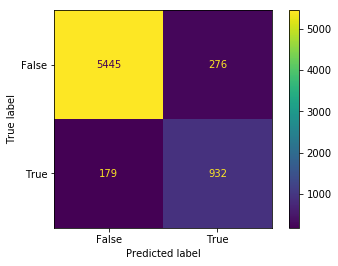

In [83]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

actual = unknown_check['pt_sending']
predicted = unknown_check['predicted']

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

# A modell prediktáló képessége a test_set-en:

Pontosság (accuracy): a helyesen osztályozott esetek aránya az összes esethez képest.
Accuracy = (5445 + 932) / (5445 + 932 + 179 + 276) = 0.9277

### Tehát a modell pontossága 92,77%.

Pontosság (precision): a pozitív osztályozású esetek közül hány helyes.
Precision = 932 / (932 + 276) = 0.7715

### Tehát a modell pontossága 77,15% a pozitív osztály esetén.

Érzékenység (recall, sensitivity): a valódi pozitív esetek közül hányat osztályozott helyesen a modell.
Recall = 932 / (932 + 179) = 0.8389

### Tehát a modell érzékenysége 83,89% a pozitív osztály esetén.

F1-pontszám (F1-score): a pontosság és az érzékenység harmonikus középértéke.
F1-score = 2 * (Precision * Recall) / (Precision + Recall) = 2 * (0.7715 * 0.8389) / (0.7715 + 0.8389) = 0.8037

### Tehát a modell F1-pontszáma 80,37%.


# A modell értékelése

Az első esetben (training set) a modell pontossága 94,5%, míg a második esetben (test set) a pontosság 92,77%. 

Az a tény, hogy a tesztelési halmazon elért pontosság valamelyest alacsonyabb a tanítási halmazon elért pontosságnál, azt jelzi, hogy a modell talán kissé túltanulta a tanítási adatokat. Ugyanakkor a különbség nem túl nagy, így a modell általánosító képessége elfogadható.

A tanítási és tesztelési halmazon elért pozitív osztályra vonatkozó mutatók összehasonlítása:

1. Tanítási halmaz:
- Precision: 81,28%
- Recall: 85,05%
- F1-score: 83,13%

2. Tesztelési halmaz:
- Precision: 77,15%
- Recall: 83,89%
- F1-score: 80,37%

A pozitív osztályra vonatkozó mutatók esetében a tesztelési halmazon a modell valamelyest alacsonyabb értékeket ér el, ami szintén azt jelezheti, hogy a modell túltanulta a tanítási adatokat. A különbség itt is mérsékelt, így a modell teljesítménye még mindig elfogadhatónak tekinthető.

### Összességében a modell teljesítménye jó, de lehetne javítani rajta. 

A túltanulás minimalizálása érdekében a modell finomhangolása, mint például a hiperparaméterek megváltoztatása vagy a regularizáció alkalmazása, segíthet javítani a modell általánosító képességét.